In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from sklearn.decomposition import PCA


In [2]:
def DefineRectangles2(FileName,PointsPerRectangle):
    #read rectangles
    RectangleRead = pd.read_csv(FileName,sep=" ",names=["x","y","nan"])
    RectangleList = RectangleRead.values.tolist()
    RectanglesAll = np.array(RectangleList)
    RectanglesAll = RectanglesAll[:,[0,1]]
    
    #define rectangles
    x = RectanglesAll[:,0]
    y = RectanglesAll[:,1]
    NumberRectangles = round(len(RectanglesAll[:,0])/PointsPerRectangle)
    RectanglesFinal = np.zeros([NumberRectangles,5])
    
    if PointsPerRectangle == 2:
        #assume opposite corners are specified
        for k in range(NumberRectangles):
            RectangleXVertices = []
            RectangleYVertices = []
            for k1 in range(PointsPerRectangle*k,PointsPerRectangle*(k+1),1):
                RectangleXVertices = np.append(RectangleXVertices,x[k1])
                RectangleYVertices = np.append(RectangleYVertices,y[k1])
            
            MinX = np.min(RectangleXVertices)
            MinY = np.min(RectangleYVertices)
            Width = np.abs([RectangleXVertices[1]-RectangleXVertices[0]])
            Height = np.abs([RectangleYVertices[1]-RectangleYVertices[0]])
            RectanglesFinal[k,:] = [MinX,MinY,Width,Height,0]
                
    else:
        #assume all 4 vertices are specified
        DistanceFromOriginVertices = np.sqrt(x**2+y**2)
        for k in range(NumberRectangles): 
            RectangleXVertices = []
            RectangleYVertices = []
            DistanceVertices = []
            for k1 in range(PointsPerRectangle*k,PointsPerRectangle*(k+1),1):
                RectangleXVertices = np.append(RectangleXVertices,x[k1])
                RectangleYVertices = np.append(RectangleYVertices,y[k1])
                DistanceVertices = np.append(DistanceVertices,DistanceFromOriginVertices[k1])
            
            MinDistanceVertices = np.min(DistanceVertices)
            MaxX = np.max(RectangleXVertices)
            MaxY = np.max(RectangleYVertices)            
            MinX = np.min(RectangleXVertices)
            MinY = np.min(RectangleYVertices)
            
            dx = RectangleXVertices-RectangleXVertices[0]
            dxCount = 0
            for k3 in range(PointsPerRectangle):
                if dx[k3] == 0:
                    dxCount = dxCount+1
            #dx will have more than one 0 element if rectangle aligned with grid
            if dxCount > 1:
                RectanglesFinal[k,:] = [MinX,MinY,MaxX-MinX,MaxY-MinY,0]
            else:            
                #find local origin and determine rectangle rotation
                for k2 in range(PointsPerRectangle):
                    if DistanceVertices[k2] == MinDistanceVertices:
                        Point0 = k2
                    if RectangleXVertices[k2] == MinX:
                        IndexMinX = k2
                    if RectangleYVertices[k2] == MinY:
                        IndexMinY = k2
                    if RectangleXVertices[k2] == MaxX:
                        IndexMaxX = k2
                    if RectangleYVertices[k2] == MaxY:
                        IndexMaxY = k2                
                if RectangleYVertices[Point0] == RectangleYVertices[IndexMinY]: #rectangle rotated +
                    Point1 = IndexMaxX
                    Point2 = IndexMinX
                if RectangleXVertices[Point0] == RectangleXVertices[IndexMinX]: #rectangle rotated -
                    Point1 = IndexMinY
                    Point2 = IndexMaxY                
                Width = np.sqrt((RectangleXVertices[Point1]-RectangleXVertices[Point0])**2+(RectangleYVertices[Point1]-RectangleYVertices[Point0])**2)
                Height = np.sqrt((RectangleXVertices[Point2]-RectangleXVertices[Point0])**2+(RectangleYVertices[Point2]-RectangleYVertices[Point0])**2)
                Angle = np.arctan((RectangleYVertices[Point1]-RectangleYVertices[Point0])/(RectangleXVertices[Point1]-RectangleXVertices[Point0]))
                RectanglesFinal[k,:] = [RectangleXVertices[Point0],RectangleYVertices[Point0],Width,Height,Angle]

    return RectanglesFinal

In [3]:
def generate_depth_image(FileName,shape,inpaintFlag):
    #code copied from https://github.com/skumra/robotic-grasping/blob/master/utils/dataset_processing/image.py
    img = np.zeros(shape)
    with open(FileName) as f:
        for l in f.readlines():
            ls = l.split()

            if len(ls) != 5:
                # Not a point line in the file.
                continue
            try:
                # Not a number, carry on.
                float(ls[0])
            except ValueError:
                continue

            i = int(ls[4])
            r = i // shape[1]
            c = i % shape[1]

            x = float(ls[0])
            y = float(ls[1])
            z = float(ls[2])
            
            #calculate distance to each point (l2 norm) in point cloud, divide by 1000 to get to m
            img[r, c] = np.sqrt(x ** 2 + y ** 2 + z ** 2)/1000

    if inpaintFlag == 1:
        """
        Inpaint missing values in depth image.
        :param missing_value: Value to fill in teh depth image.
        """
        # cv2 inpainting doesn't handle the border properly
        # https://stackoverflow.com/questions/25974033/inpainting-depth-map-still-a-black-image-border
        img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
        mask = (img == 0).astype(np.uint8)

        # Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
        scale = np.abs(img).max()
        img = img.astype(np.float32) / scale  # Has to be float32, 64 not supported.
        img = cv2.inpaint(img, mask, 1, cv2.INPAINT_NS)

        # Back to original size and value range.
        img = img[1:-1, 1:-1]
        img = img * scale
    
    return img


In [49]:
def CreatePatch2(RGBDImage,Rectangles):
    #define rectangle in grid
    for k in range(len(Rectangles[:,0])):
        xLocal = range(Rectangles[k,2].astype(int))
        yLocal = range(Rectangles[k,3].astype(int))
        XLocal,YLocal = np.meshgrid(xLocal,yLocal)
        #rotate local rectangle to align with image grid
        X = (XLocal*np.cos(Rectangles[k,4])-YLocal*np.sin(Rectangles[k,4]))+Rectangles[k,0]
        Y = (XLocal*np.sin(Rectangles[k,4])+YLocal*np.cos(Rectangles[k,4]))+Rectangles[k,1]
        RGBDPatch = RGBDImage[Y.astype(int),X.astype(int),:]
        
        ######### doesn't work!!
        #pca on depth channel
        Depth = RGBDPatch[:,:,3]
        #break up image into nxn sub-images
        xpixels = 9
        ypixels = 9
        if len(RGBDPatch[:,0]) >= xpixels*4 and len(RGBDPatch[0,:]) >= ypixels*4:
            NumberSubImagesX = np.floor(len(RGBDPatch[:,0])/xpixels)
            NumberSubImagesY = np.floor(len(RGBDPatch[0,:])/ypixels)
            NumberSubImagesX = NumberSubImagesX.astype(int)
            NumberSubImagesY = NumberSubImagesY.astype(int)
            print(NumberSubImagesX)
            print(NumberSubImagesY)
            xindex = np.linspace(0,xpixels-1,xpixels)
            yindex = np.linspace(0,ypixels-1,ypixels)
            DepthPCA = np.zeros([xpixels*ypixels,NumberSubImagesX*NumberSubImagesY])
            PCAindex = 0
            for k1 in range(NumberSubImagesY):
                for k2 in range(NumberSubImagesX):
                    xsub = xindex+k2*xpixels
                    ysub = yindex+k1*ypixels
                    Xsub,Ysub = np.meshgrid(xsub,ysub)
                    DepthSub = Depth[Xsub.astype(int),Ysub.astype(int)]
                    DepthPCA[:,PCAindex] = DepthSub.flatten()
                    PCAindex = PCAindex+1

            #apply pca whitening
            pca = PCA(whiten="true")
            whitened_depth = pca.fit_transform(DepthPCA)
            #map sub images back to original pixels
            DepthWhitened = np.zeros(Depth.shape)
            PCAindex = 0
            for k1 in range(NumberSubImagesY):
                for k2 in range(NumberSubImagesX):
                    xsub = xindex+k2*xpixels
                    ysub = yindex+k1*ypixels
                    Xsub,Ysub = np.meshgrid(xsub,ysub)
                    whitened_depth_sub = whitened_depth[:,PCAindex].reshape(ypixels,xpixels)
                    DepthWhitened[Xsub.astype(int),Ysub.astype(int)] = whitened_depth_sub
                    PCAindex = PCAindex+1
        else:
            DepthWhitened = Depth

        ###########
        
        #original_shape = Depth.shape
        #flattened_depth = Depth.flatten().reshape(-1, 1)
        #pca = PCA(whiten="true")
        #whitened_depth = pca.fit_transform(flattened_depth)
        #whitened_depth = whitened_depth.reshape(original_shape)
        #RGBDPatch[:,:,3] = whitened_depth
        
        #how to pad this to get all patches to same size?
        
        #convert rgb channels to yuv channels
        YUVDPatch = RGBDPatch
        yuv = cv2.cvtColor(RGBDPatch[:,:,[0,1,2]].astype(np.uint8), cv2.COLOR_BGR2YUV)
        YUVDPatch[:,:,[0,1,2]] = yuv
        
        #write YUVDPatch to a new file
        
        
        #plot yuv patches
        plt.subplot(1,3,1)
        plt.imshow(YUVDPatch[:,:,[0,1,2]].astype(np.uint8))
        plt.title('YUV')
        #plot depth channel
        plt.subplot(1,3,2)
        plt.imshow(Depth,cmap="gray")
        plt.title('Depth')
        #plot whitened depth channel
        plt.subplot(1,3,3)
        plt.imshow(DepthWhitened,cmap="gray")
        plt.title('Depth Whitened')
        plt.show()
    #return YUVDPatch
        

In [42]:
#load data files
data_folder = os.path.join(os.path.dirname(os.getcwd()), "data_592", "robotics_grasp", "10")
print("Current Directory:", data_folder)

cneg_pattern = "*cneg.txt"
cpos_pattern = "*cpos.txt"
pcd_pattern = "pcd[0-9][0-9][0-9][0-9].txt"
png_pattern = "*.png"
tiff_pattern = "*.tiff"

cneg_files = sorted(glob.glob(os.path.join(data_folder, cneg_pattern)))
cpos_files = sorted(glob.glob(os.path.join(data_folder, cpos_pattern)))
pcd_files = sorted(glob.glob(os.path.join(data_folder, pcd_pattern)))
png_files = sorted(glob.glob(os.path.join(data_folder, png_pattern)))

ImageIndex = 34
FileNameImage = png_files[ImageIndex]
FileNameDepthImage = pcd_files[ImageIndex]
FileNameNegRect = cneg_files[ImageIndex]
FileNamePosRect = cpos_files[ImageIndex]


Current Directory: /home/exouser/ME592_Spring2024/data_592/robotics_grasp/10


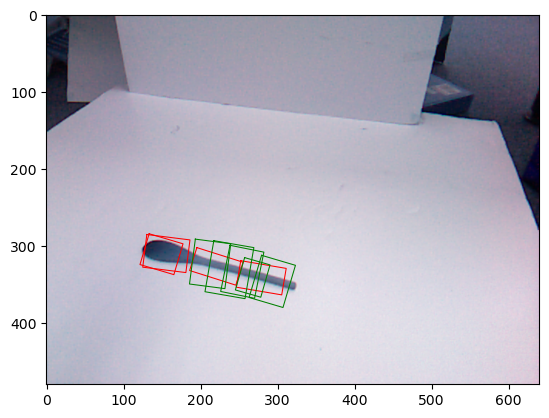

[480, 640, 4]


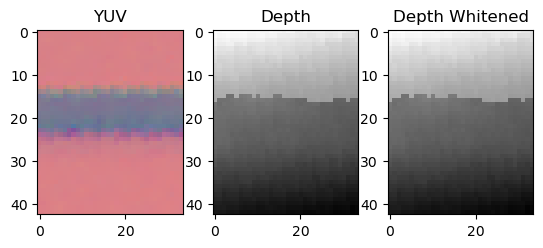

6
4


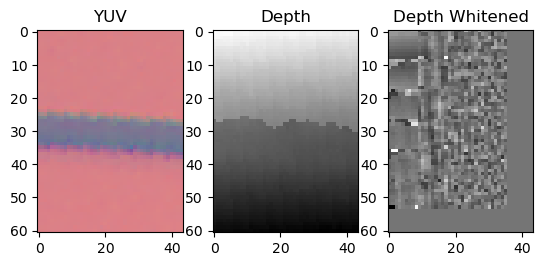

6
5


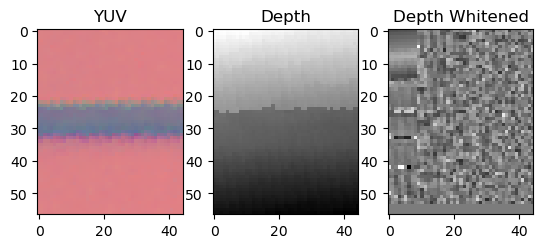

7
5


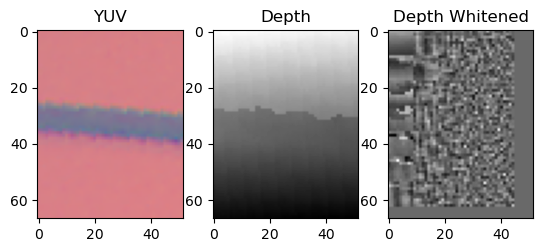

6
5


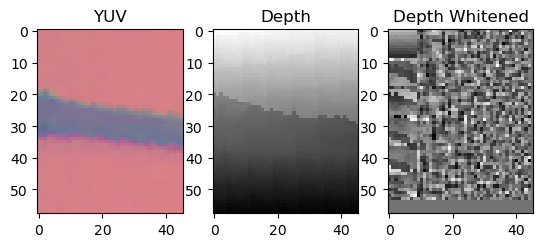

In [50]:
#process data files

#load image
Image1 = cv2.imread(FileNameImage)
shape = [len(Image1[:,0]),len(Image1[0,:])]

#define grasping triangles
PointsPerRectangle = 4
RectanglesNegative = DefineRectangles2(FileNameNegRect,PointsPerRectangle)
RectanglesPositive = DefineRectangles2(FileNamePosRect,PointsPerRectangle)

#create depth image
inpaintFlag = 1;
depth_image = generate_depth_image(FileNameDepthImage,shape,inpaintFlag)

#plot image with grasping triangles
plt.imshow(Image1)
for k in range(len(RectanglesNegative[:,0])):
    #build, rotate, and translate rectangles
    xLocal = np.array([0,RectanglesNegative[k,2],RectanglesNegative[k,2],0,0])
    yLocal = np.array([0,0,RectanglesNegative[k,3],RectanglesNegative[k,3],0])
    xvalues = (xLocal*np.cos(RectanglesNegative[k,4])-yLocal*np.sin(RectanglesNegative[k,4]))+RectanglesNegative[k,0]
    yvalues = (xLocal*np.sin(RectanglesNegative[k,4])+yLocal*np.cos(RectanglesNegative[k,4]))+RectanglesNegative[k,1]
    plt.plot(xvalues,yvalues,color="red",linewidth=0.75)
for k in range(len(RectanglesPositive[:,0])):
    #build, rotate, and translate rectangles
    xLocal = np.array([0,RectanglesPositive[k,2],RectanglesPositive[k,2],0,0])
    yLocal = np.array([0,0,RectanglesPositive[k,3],RectanglesPositive[k,3],0])
    xvalues = (xLocal*np.cos(RectanglesPositive[k,4])-yLocal*np.sin(RectanglesPositive[k,4]))+RectanglesPositive[k,0]
    yvalues = (xLocal*np.sin(RectanglesPositive[k,4])+yLocal*np.cos(RectanglesPositive[k,4]))+RectanglesPositive[k,1]   
    plt.plot(xvalues,yvalues,color="green",linewidth=0.75)
plt.show()

#build rgbd image array
rgbd_image = np.zeros([len(Image1[:,0]),len(Image1[0,:]),4])
rgbd_image[:,:,[0,1,2]] = Image1
rgbd_image[:,:,3] = depth_image
print([len(rgbd_image[:,0,0]),len(rgbd_image[0,:,0]),len(rgbd_image[0,0,:])])
#rgb in rgbd image is now a float, need to convert back to uint8 before plotting
#and converting to yuv

#build patches
CreatePatch2(rgbd_image,RectanglesPositive)